# Wikimedia Discovery Analysis

### import libraries

In [1]:
library(dplyr)
library(ggplot2)
library(reshape2)
library(readr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Read Data

### The data is stored as csv, the timestamp column is a string where year, month, day, hour, minute second are pasted together.
### First we need to convert this to a proper date format to use the timestamps

In [2]:
events_log_ts_fixed = suppressMessages(read_csv("events_log.csv")) %>% 
  mutate(timestamp =  as.POSIXct(as.character(timestamp), 
                                 format = "%Y%m%d%H%M%S", 
                                 origin = as.Date("1970-01-01")))

### Data Overview

In [3]:
head(events_log_ts_fixed, 15)
summary(events_log_ts_fixed  %>% 
        select(-c(uuid, session_id, group, action, page_id)))

uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
<chr>,<dttm>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NA,cbeb66d1bc1f1bc2,5,NA
00000c69fe345268935463abbfa5d5b3,2016-03-07 00:52:26,c559c3be98dca8a4,a,searchResultPage,NA,eb658e8722aad674,10,NA
00003bfdab715ee59077a3670331b787,2016-03-02 14:53:05,760bf89817ce4b08,a,checkin,30,f99a9fc1f7fdd21e,NA,NA
0000465cd7c35ad2bdeafec953e08c1a,2016-03-02 22:27:01,fb905603d31b2071,a,checkin,60,e5626962a6939a75,NA,10
000050cbb4ef5b42b16c4d2cf69e6358,2016-03-02 09:50:23,c2bf5e5172a892dc,a,checkin,30,787dd6a4c371cbf9,NA,NA
0000a6af2baa5af1be2431e84cb01da1,2016-03-02 11:29:45,f6840a9614c527ad,a,checkin,180,6fb7b9ea87012975,NA,NA
0000cd61e11d5371adf974703cd4f7e7,2016-03-01 05:54:57,51f4d3b6a8688e56,a,checkin,240,8ad97e7c85c58e80,NA,NA
000104fe220a5675a270420cd6d4d4ac,2016-03-02 01:28:45,485eabe5374f09e4,b,searchResultPage,NA,4da9a64232ce947b,15,NA
00012e37b74c59a8911514c894402406,2016-03-03 11:32:55,91174a537d79a0c7,a,checkin,180,dfdff179047ea086,NA,1


   timestamp                      checkin         n_results     
 Min.   :2016-03-01 00:00:01   Min.   : 10.00   Min.   :  0.00  
 1st Qu.:2016-03-02 16:47:05   1st Qu.: 20.00   1st Qu.:  2.00  
 Median :2016-03-04 12:10:52   Median : 50.00   Median : 20.00  
 Mean   :2016-03-04 18:39:43   Mean   : 97.19   Mean   : 13.21  
 3rd Qu.:2016-03-06 22:01:09   3rd Qu.:150.00   3rd Qu.: 20.00  
 Max.   :2016-03-08 20:24:32   Max.   :420.00   Max.   :500.00  
 NA's   :4                     NA's   :176341   NA's   :263931  
 result_position  
 Min.   :   1.00  
 1st Qu.:   1.00  
 Median :   1.00  
 Mean   :   2.99  
 3rd Qu.:   2.00  
 Max.   :4103.00  
 NA's   :169683   

### We can observe the dataset has a lot of NA values in multiple comlumns, this is expected as the "n_results", "result_position", "checkin" are expected to be missing from rows where these values  do not correspond to them. E.g for "checkin" event we will not have "n_results" 

### Which results do people tend to try first? How does it change day-to-day?

In [4]:
result_position_df = events_log_ts_fixed %>% 
  mutate(date = as.Date(timestamp)) %>% 
  select(result_position, date) %>% na.omit()

In [5]:
result_position_df$result_position %>% table %>% as.data.frame %>% 
    setNames(c("result_position", "frequency"))  %>% head(10)

,result_position,frequency
,<fct>,<int>
1,1,149352
2,2,31779
3,3,16234
4,4,8698
5,5,5334
6,6,3943
7,7,2833
8,8,1775
9,9,1380


#### From the above table we can observe that a large no. of the users choose the 1st result 

#### To find out result position which is mostly preferred by users, we only need the frequnency of the result positions

In [6]:
# Get the summarised data for preffered top 10 results
result_position_overall = result_position_df %>% 
  group_by(result_position) %>%
  summarise(count = n()) %>% 
    mutate(percentage_count = 100*(count/sum(count))) %>% 
    top_n(percentage_count, n = 20) %>% 
    ungroup() %>% as.data.frame()

`summarise()` ungrouping output (override with `.groups` argument)



In [7]:
result_position_overall %>% head(10)

,result_position,count,percentage_count
,<dbl>,<int>,<dbl>
1,1,149352,64.8004165
2,2,31779,13.7881812
3,3,16234,7.0435613
4,4,8698,3.7738632
5,5,5334,2.3143006
6,6,3943,1.7107775
7,7,2833,1.2291739
8,8,1775,0.7701319
9,9,1380,0.5987504


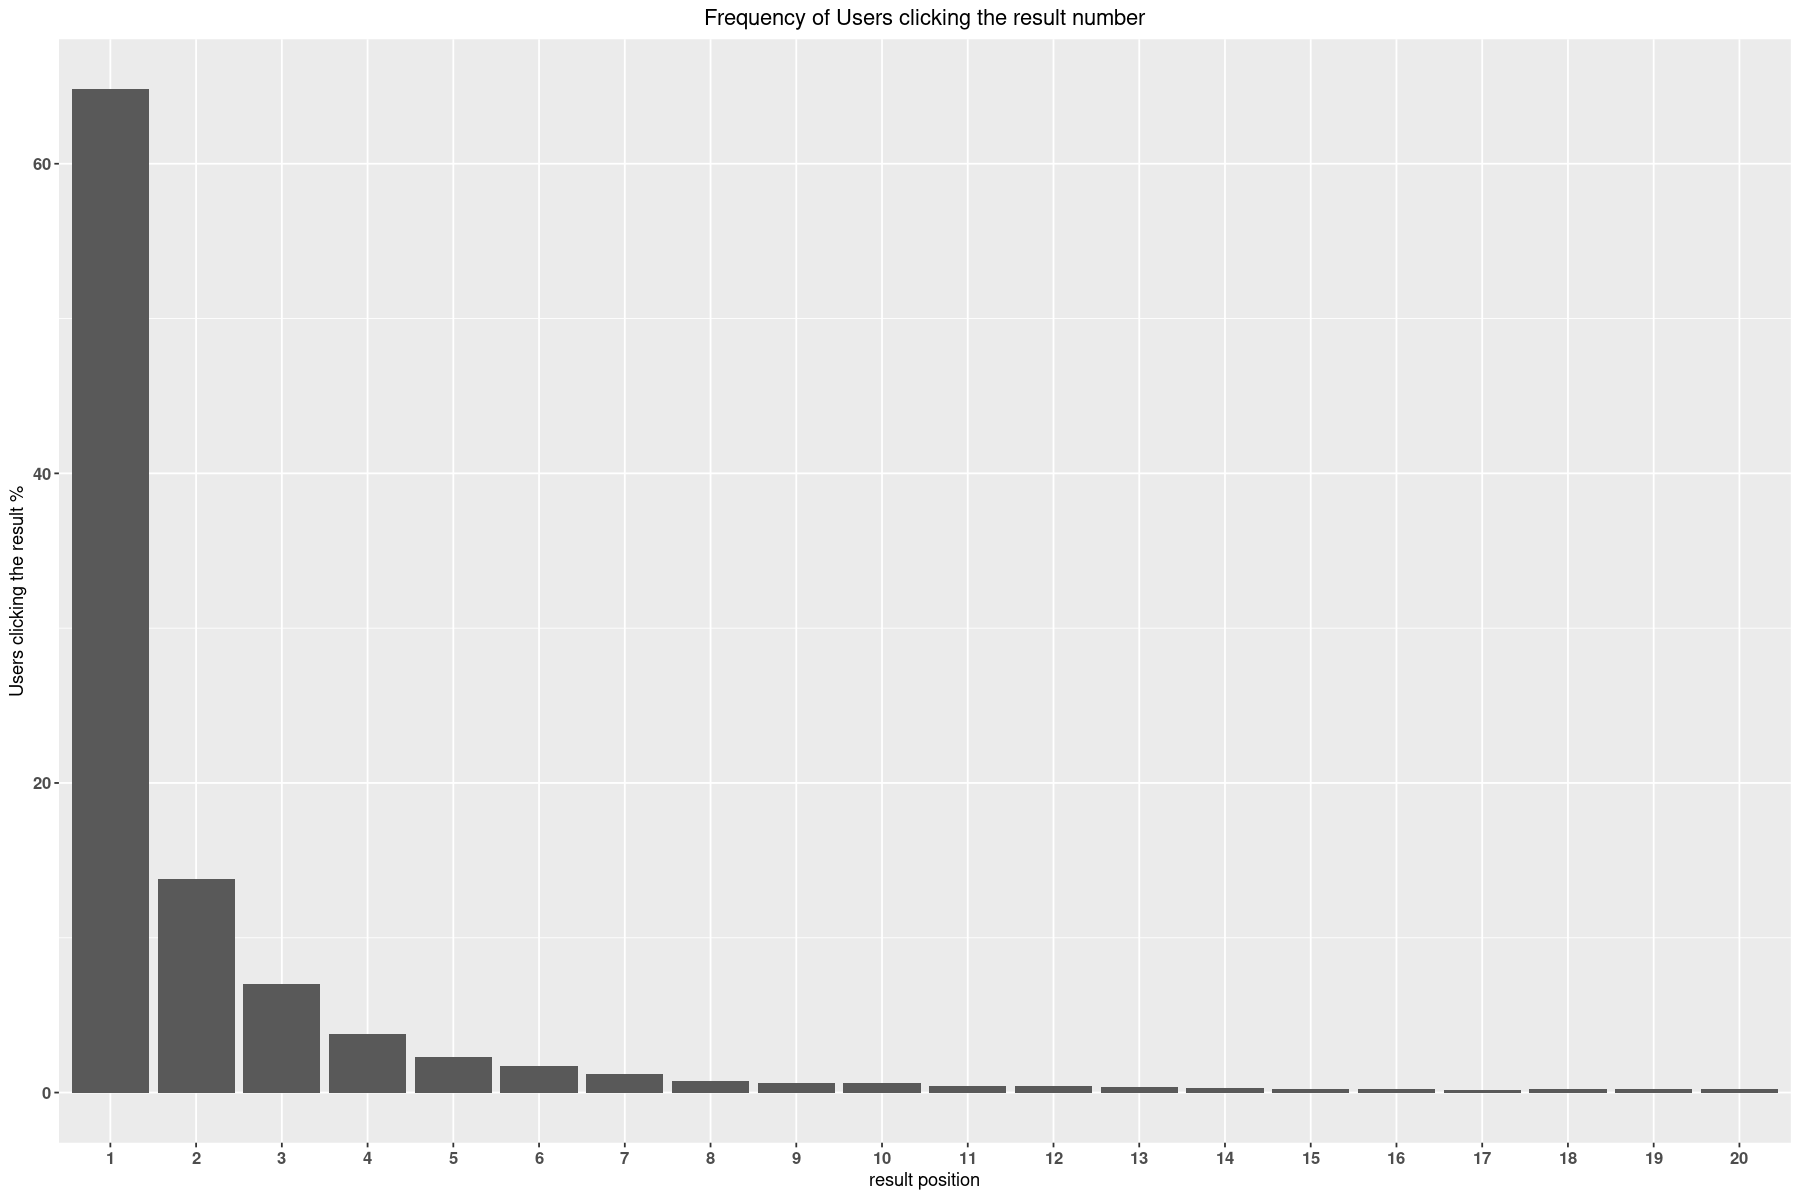

In [18]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data= result_position_overall, 
       aes(x=factor(result_position), y=percentage_count)) + 
  geom_bar(stat="identity") + ylab("Users clicking the result %") + xlab("result position") +
  theme(axis.text.x = element_text(face = "bold", size = 10),
        axis.text.y = element_text(face = "bold", size = 10),
        plot.title = element_text(hjust = 0.5)) +
  ggtitle("Frequency of Users clicking the result number")

#### Around 65% of users click on the first shown result, followed by 14% of the users choosing the second one. Amount of users going beyond the 7th result is negligible. 

In [19]:
result_position_by_date = result_position_df %>% 
  group_by(date, result_position) %>%
  summarise(count = n()) %>% 
    mutate(percentage_count = 100*(count/sum(count))) %>% 
    top_n(percentage_count, n = 10) %>% 
    ungroup() %>% as.data.frame()

`summarise()` regrouping output by 'date' (override with `.groups` argument)



In [20]:
result_position_by_date %>% head(10)

,date,result_position,count,percentage_count
,<date>,<dbl>,<int>,<dbl>
1,2016-02-29,1,2813,65.8011696
2,2016-02-29,2,669,15.6491228
3,2016-02-29,3,236,5.5204678
4,2016-02-29,4,162,3.7894737
5,2016-02-29,5,96,2.2456140
6,2016-02-29,6,50,1.1695906
7,2016-02-29,7,26,0.6081871
8,2016-02-29,10,38,0.8888889
9,2016-02-29,11,28,0.6549708


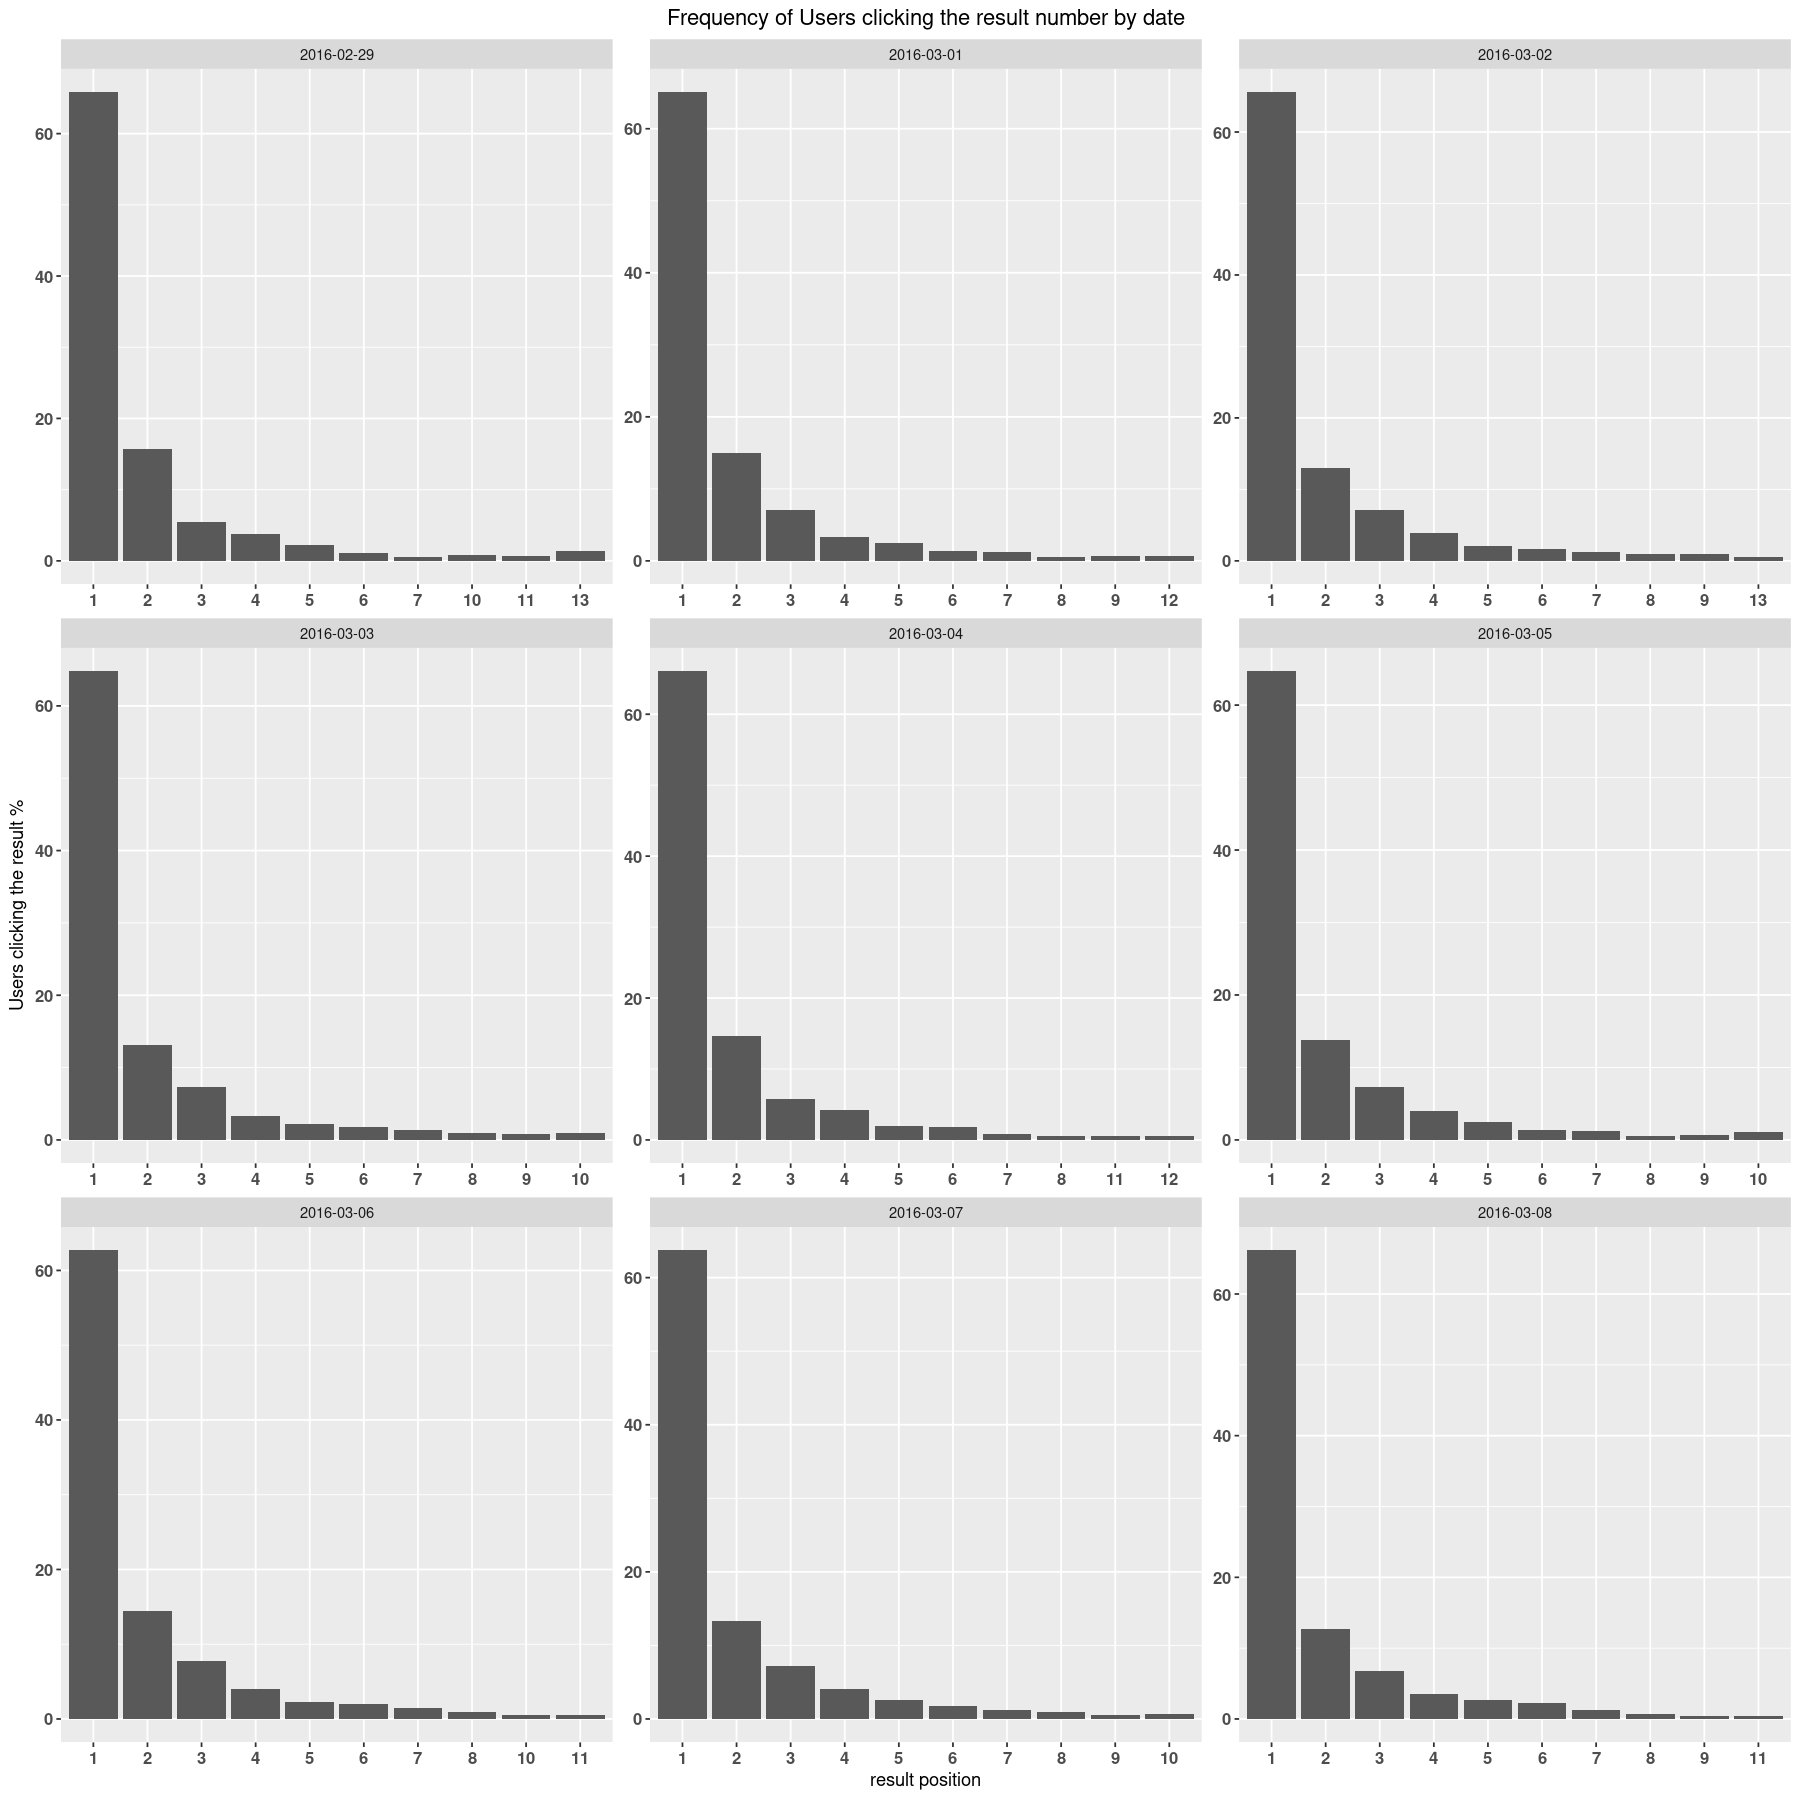

In [22]:
options(repr.plot.width=15, repr.plot.height=15)
ggplot(data= result_position_by_date, 
       aes(x=factor(result_position), y=percentage_count)) + 
  geom_bar(stat="identity") + ylab("Users clicking the result %") + xlab("result position") +
  facet_wrap("date", scales = "free") + 
  theme(axis.text.x = element_text(face = "bold", size = 10),
        axis.text.y = element_text(face = "bold", size = 10),
        plot.title = element_text(hjust = 0.5)) +
  ggtitle("Frequency of Users clicking the result number by date")

#### The prefernce of the result position doesn't change much on day by day basis as compared to overall figures, for all the days the top preferred result is the 1st one ~65% and beyond the 7th result it's negligible. 

In [24]:
suppressWarnings({
events_session_group = 
  events_log_ts_fixed %>% 
  mutate(date = as.Date(timestamp)) %>% 
  group_by(session_id) %>% 
  arrange(timestamp) %>%
  summarise(user_group = group[1],
            date = as.Date(timestamp[1]),
            session_time = max(checkin, na.rm = T),
            minimum_n_results = min(n_results, na.rm = T),
            num_serp_visits = sum(action == "searchResultPage"),
            num_results_clicked = sum(action == "visitPage"),
            order_of_events = paste(unique(action), collapse = "-->"),
            num_unique_pages_visited = length(unique(page_id))) %>% 
  mutate(session_time = ifelse(session_time == -Inf, NA, session_time),
         minimum_n_results = ifelse(minimum_n_results == Inf, NA, minimum_n_results)) %>% as.data.frame})

`summarise()` ungrouping output (override with `.groups` argument)



### In the above block of code, we summarise the dataset by session ID's to get the metrics per session. 
### Here we introduce some new variables :
#### 1. session_time : the approximate time of each session. 
#### 2. minimum_num_rusults : no. of results returned atleast in a session, could be from multiple search queries. 
#### 3. num_serp_visits : number of times the search page was visited in a single session 
#### 4. num_results_clicked : number of times a user clicked on a  search result in a single session
#### 5. order_of_events : the order in which a session progressed, this is mainly to check if each session followed the ideal order of search -> click on result -> visited page
#### 6. num_unique_pages_visited : number of different pages visited in a single session


In [25]:
events_session_group  %>% arrange(desc(num_unique_pages_visited)) %>% 
select(-c(session_id))  %>% head(10)

,user_group,date,session_time,minimum_n_results,num_serp_visits,num_results_clicked,order_of_events,num_unique_pages_visited
,<chr>,<date>,<dbl>,<dbl>,<int>,<int>,<chr>,<int>
1,a,2016-03-01,NA,0,484,0,searchResultPage,484
2,a,2016-03-03,NA,0,221,0,searchResultPage,221
3,a,2016-03-04,NA,0,198,0,searchResultPage,198
4,a,2016-03-04,180,8,107,75,searchResultPage-->visitPage-->checkin,182
5,a,2016-03-05,180,0,129,21,searchResultPage-->visitPage-->checkin,150
6,a,2016-02-29,NA,0,130,0,searchResultPage,130
7,a,2016-03-03,60,4,106,12,searchResultPage-->visitPage-->checkin,118
8,a,2016-03-03,NA,0,113,0,searchResultPage,113
9,a,2016-03-02,NA,4,59,51,searchResultPage-->visitPage,110


### Here we see some odd behaviour of users in the top 3 sessions with maximum no. of pages visited, where the user never clicks on any result but makes only search queries (we can see that the order of events do not have any visitPage event), in my opinion, these are bots scraping links. 

In [26]:
events_session_group %>% 
    group_by(user_group, order_of_events) %>% 
    summarize(count = n()) %>% 
    arrange(desc(count))  %>% head(10)

`summarise()` regrouping output by 'user_group' (override with `.groups` argument)



user_group,order_of_events,count
<chr>,<chr>,<int>
b,searchResultPage,31820
a,searchResultPage-->visitPage-->checkin,17449
a,searchResultPage,9714
b,searchResultPage-->visitPage-->checkin,5723
a,searchResultPage-->visitPage,2228
b,searchResultPage-->visitPage,963
b,visitPage-->checkin,51
b,searchResultPage-->checkin,20
b,checkin,15


### This odd behaviour of users is further substantiated by the frequency of sessions where only the search result page is accessed. It is disproportionately high in users from group "b", and could be possible the most users from group "b" are not real humans!!


### Also apart from the ideal order of events "searchResultPage-->visitPage-->checkin", the other type of order of events such as "searchResultPage-->visitPage",    "visitPage-->checkin-->searchResultPage",                                               searchResultPage-->checkin"  &    "checkin" are there because the sampling duration of data collection is 10 seconds which is quite low, and users/bots can quickly move from one page to another without getting registered from all the activity they do

### Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.


In [27]:
correlation_matrix = events_session_group %>% 
  filter(!is.na(session_time) & !is.na(minimum_n_results)) %>% 
  select(session_time, minimum_n_results, num_serp_visits, 
         num_results_clicked, num_unique_pages_visited) %>% 
  cor() %>% round(4) %>% melt()

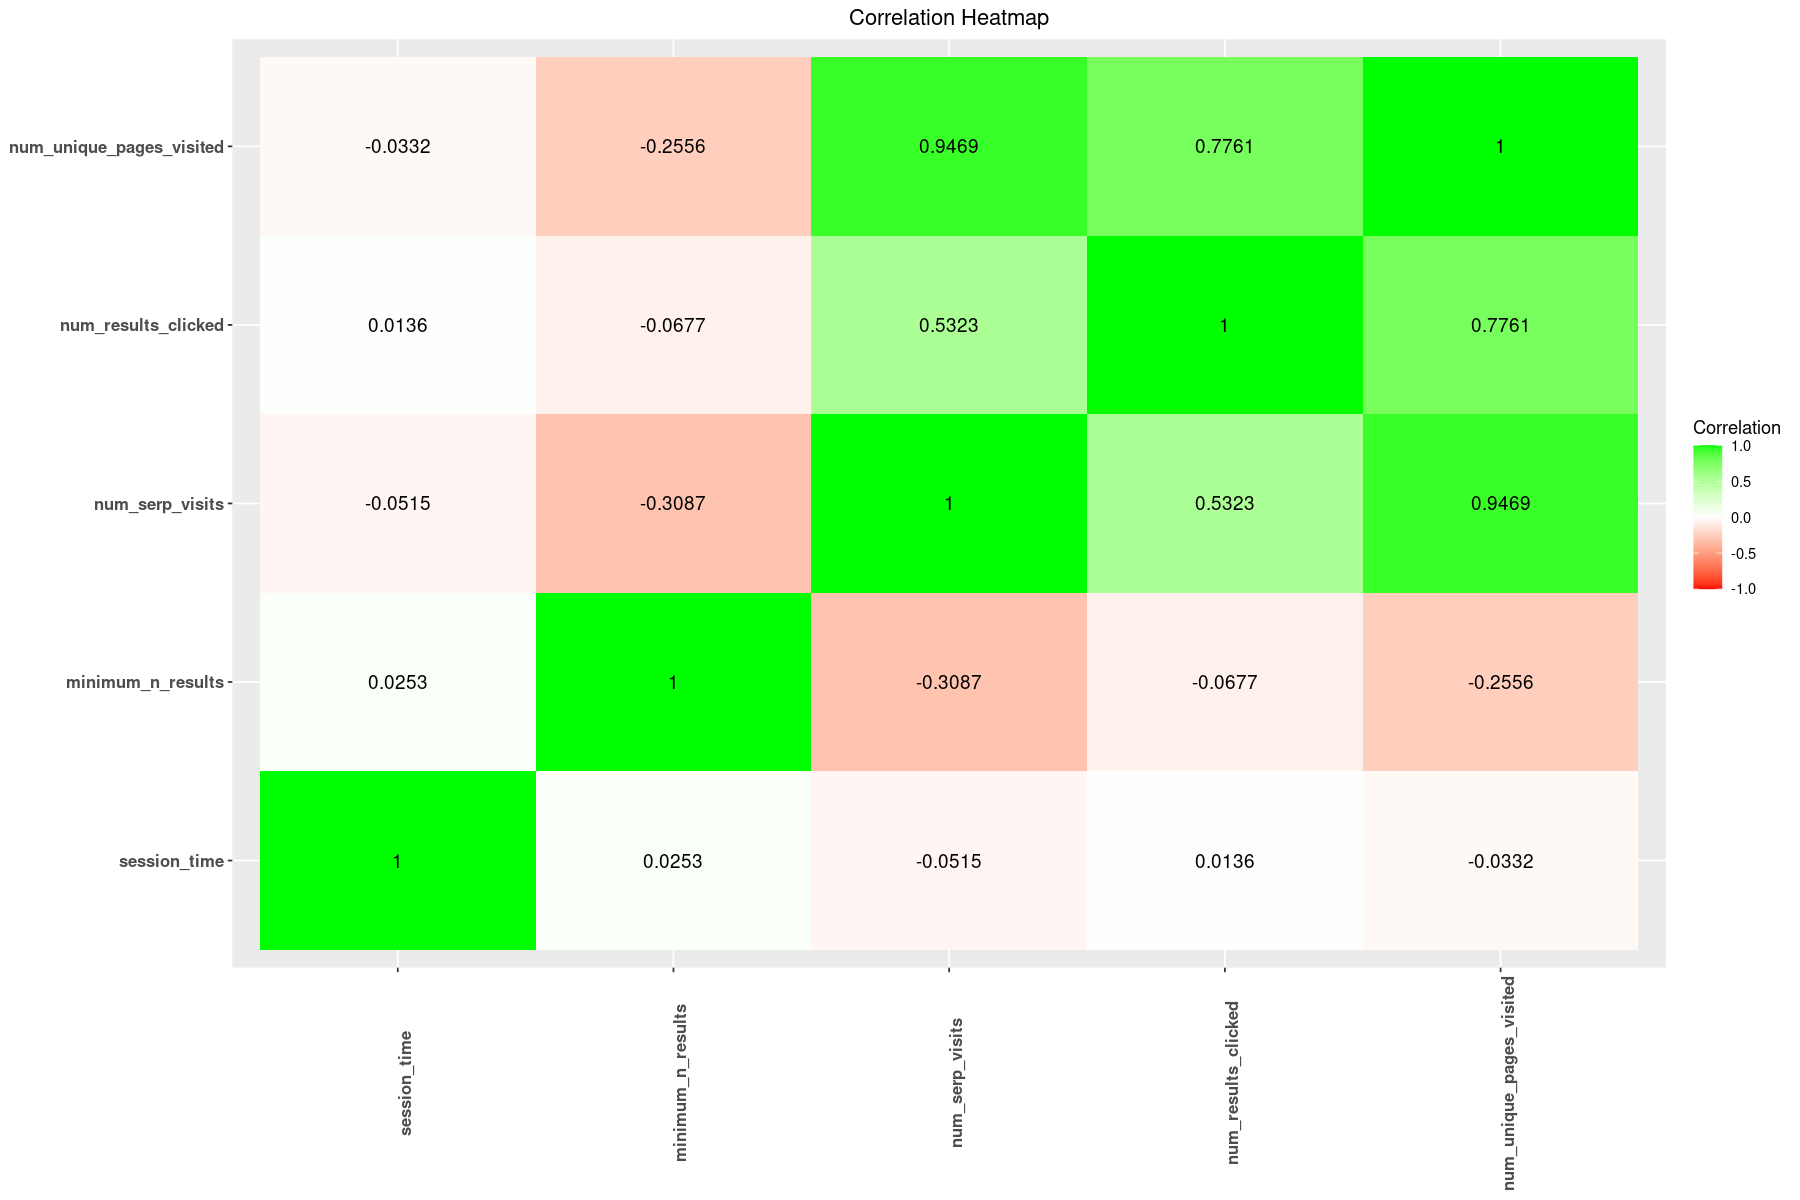

In [28]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data = correlation_matrix, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile() +
  geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) + 
  scale_fill_gradient2(low = "red", high = "green", 
                       midpoint = 0, limit = c(-1,1), space = "Lab", 
                       name="Correlation") +
  theme( axis.title.x = element_blank(), axis.title.y = element_blank(),
         axis.text.x = element_text(angle = 90, face = "bold", size = 10),
         axis.text.y = element_text(face = "bold", size = 10),
         plot.title = element_text(hjust = 0.5)) +
  ggtitle("Correlation Heatmap")

### As discussed about the odd behaviour of some sessions it is expected to have high correlation among no. of pages visited vs no. of times search page was visited, but we do NOT see any strong correlation for the session time for a user from any of the given variables. In my opinion most users who spend considerable amount of time in wikipedia are thouse who reads a page fully, hence going over multiple results or doing multiple searches does not help us identify that.  

### What is our daily overall clickthrough rate? How does it vary between the groups?

In [29]:
sum(events_session_group$num_results_clicked > 0)*100/length(events_session_group$num_results_clicked)

[1] 38.88399

#### Hence the overall clickthrough rate in the dataset is ~39%

In [30]:
# Function to summarise clickthrough rate
summarize_clickthrough_rate <- function(grouped_df){
  grouped_df %>% 
  summarise(count = n(), 
            atleast_one_result_clicked = sum(num_results_clicked>0)) %>% 
    mutate(percentage_clickthrough = 100*(atleast_one_result_clicked/count)) %>% 
    ungroup() %>% as.data.frame()
}

In [31]:
clickthrough_rate_overall = events_session_group %>% 
  group_by(user_group) %>%
  summarize_clickthrough_rate()

`summarise()` ungrouping output (override with `.groups` argument)



In [32]:
clickthrough_rate_overall

user_group,count,atleast_one_result_clicked,percentage_clickthrough
<chr>,<int>,<int>,<dbl>
a,29427,19706,66.96571
b,38601,6746,17.47623


#### Clickthrough rate by users

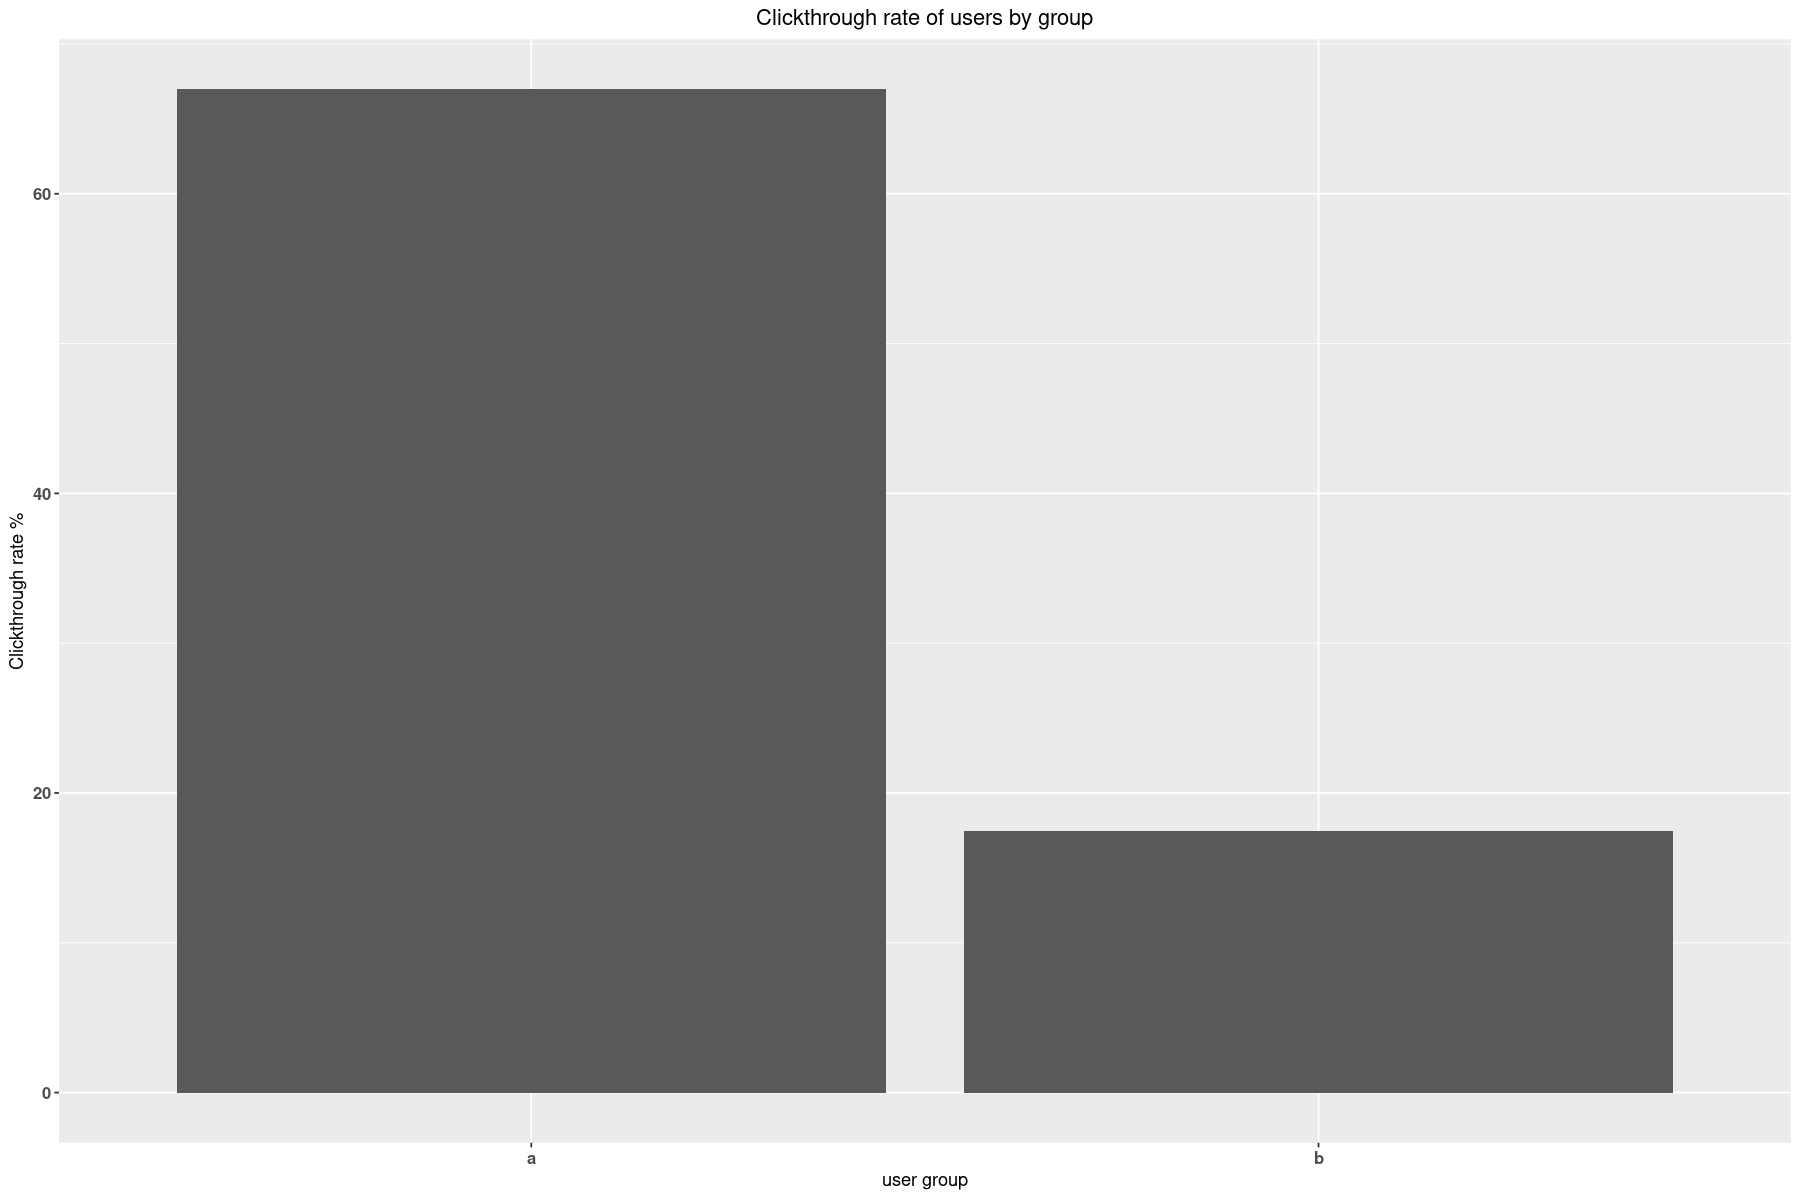

In [33]:
ggplot(data= clickthrough_rate_overall, 
       aes(x=factor(user_group), y=percentage_clickthrough)) + 
  geom_bar(stat="identity") + ylab("Clickthrough rate %") + xlab("user group") +
  theme(axis.text.x = element_text(face = "bold", size = 10),
        axis.text.y = element_text(face = "bold", size = 10),
        plot.title = element_text(hjust = 0.5)) + 
  ggtitle("Clickthrough rate of users by group")

### We can notice that the clickthrough rate of users from group a is much higher as compared to users from group b. We earlier saw that users from group b are mostly visiting only the search page and not clicking on any links. Hence we can confirm they are most likely not real users but bots. 

In [22]:
clickthrough_rate_by_date = events_session_group %>% 
  group_by(date, user_group) %>%
  summarize_clickthrough_rate()

`summarise()` regrouping output by 'date' (override with `.groups` argument)



In [23]:
clickthrough_rate_by_date

date,user_group,count,atleast_one_result_clicked,percentage_clickthrough
<date>,<chr>,<int>,<int>,<dbl>
2016-02-29,a,652,442,67.79141
2016-02-29,b,722,93,12.88089
2016-03-01,a,4191,2811,67.07230
2016-03-01,b,5090,721,14.16503
2016-03-02,a,4188,2870,68.52913
2016-03-02,b,4956,704,14.20500
2016-03-03,a,4111,2770,67.38020
2016-03-03,b,5135,837,16.29990
2016-03-04,a,3396,2300,67.72674


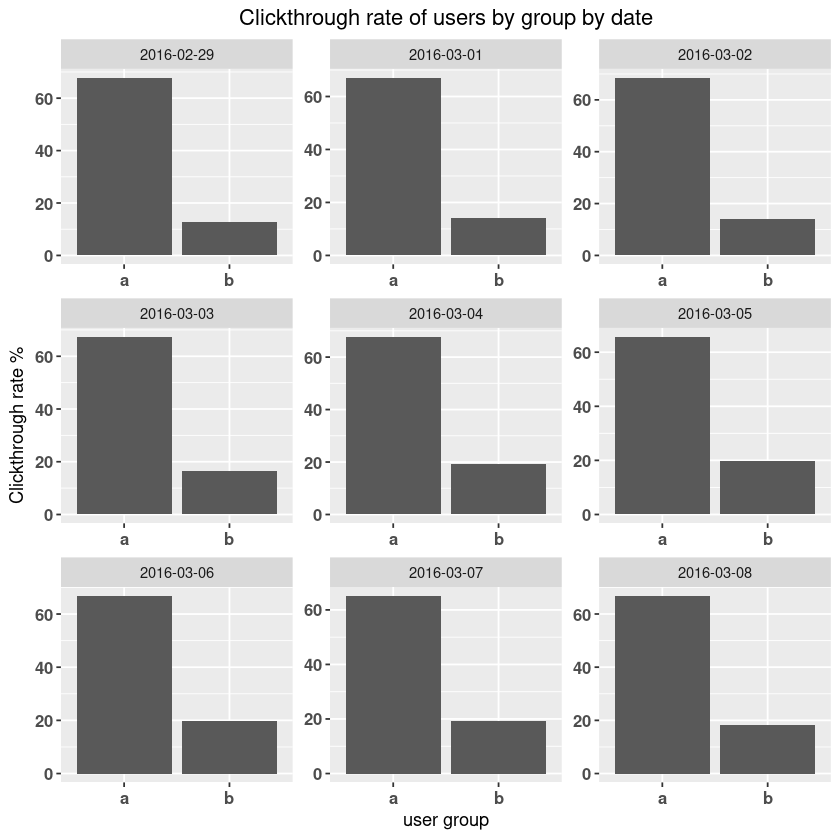

In [24]:
ggplot(data= clickthrough_rate_by_date, 
       aes(x=factor(user_group), y=percentage_clickthrough)) + 
  geom_bar(stat="identity") + ylab("Clickthrough rate %") + xlab("user group") + 
  theme(axis.text.x = element_text(face = "bold", size = 10),
        axis.text.y = element_text(face = "bold", size = 10),
        plot.title = element_text(hjust = 0.5)) +
  facet_wrap("date", scales = "free") +
  ggtitle("Clickthrough rate of users by group by date")

### On a day to day basis this behaviour from the 2 groups of users don't change, and users from group a consistently have a higher clickthroug rate.

### What is our daily overall zero results rate? How does it vary between the groups?

In [25]:
sum(events_session_group$minimum_n_results == 0, na.rm = T)*100/length(events_session_group$minimum_n_results)

[1] 20.92815

#### The overall zero result from all the searches is ~21%

In [26]:
summarize_zero_results <- function(grouped_df){
  grouped_df %>% 
    summarise(count = n(), 
            num_zero_results = sum(minimum_n_results==0, na.rm = T)) %>% 
    mutate(percentage_zero_results = 100*(num_zero_results/count))
}

In [27]:
zero_results_overall = events_session_group %>% 
  group_by(user_group) %>%
  summarize_zero_results()

`summarise()` ungrouping output (override with `.groups` argument)



In [28]:
zero_results_overall

user_group,count,num_zero_results,percentage_zero_results
<chr>,<int>,<int>,<dbl>
a,29427,6822,23.18279
b,38601,7415,19.20935


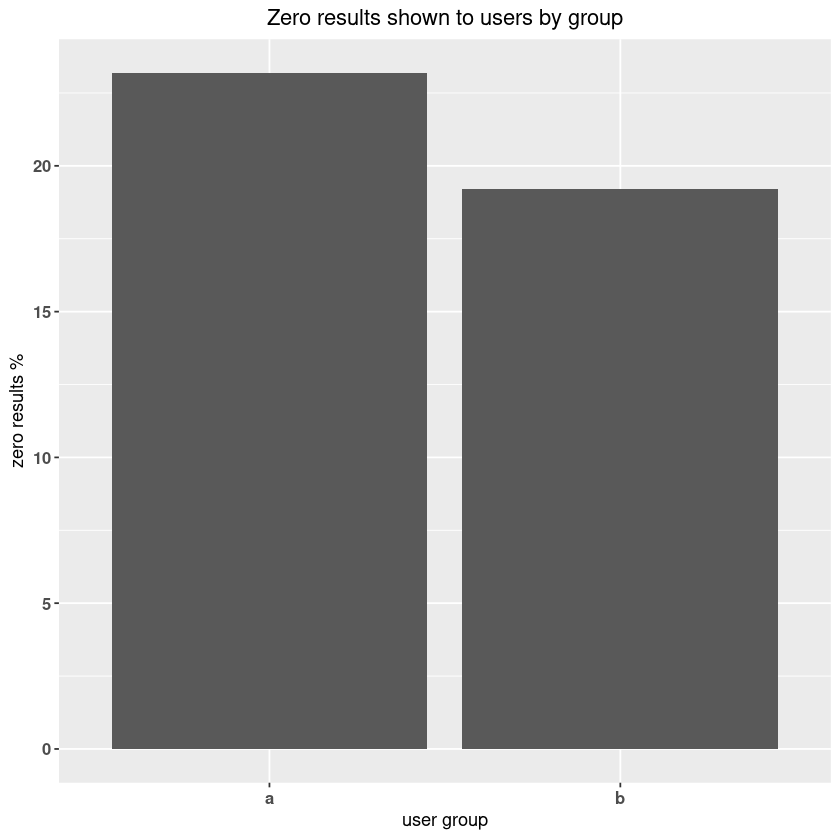

In [29]:
ggplot(data= zero_results_overall, 
       aes(x=factor(user_group), y=percentage_zero_results)) + 
  geom_bar(stat="identity") + ylab("zero results %") + xlab("user group") +
  theme(axis.text.x = element_text(face = "bold", size = 10),
        axis.text.y = element_text(face = "bold", size = 10),
        plot.title = element_text(hjust = 0.5)) +
  ggtitle("Zero results shown to users by group")

### The overall zero results by both the group of users a & b are quite similar at 23% & 19% respectively.

In [30]:
zero_results_by_date = events_session_group %>% 
  group_by(date, user_group) %>%
  summarize_zero_results()

`summarise()` regrouping output by 'date' (override with `.groups` argument)



In [31]:
zero_results_by_date

date,user_group,count,num_zero_results,percentage_zero_results
<date>,<chr>,<int>,<int>,<dbl>
2016-02-29,a,652,141,21.62577
2016-02-29,b,722,151,20.91413
2016-03-01,a,4191,945,22.54832
2016-03-01,b,5090,991,19.46955
2016-03-02,a,4188,934,22.30181
2016-03-02,b,4956,935,18.86602
2016-03-03,a,4111,958,23.30333
2016-03-03,b,5135,970,18.88997
2016-03-04,a,3396,748,22.02591


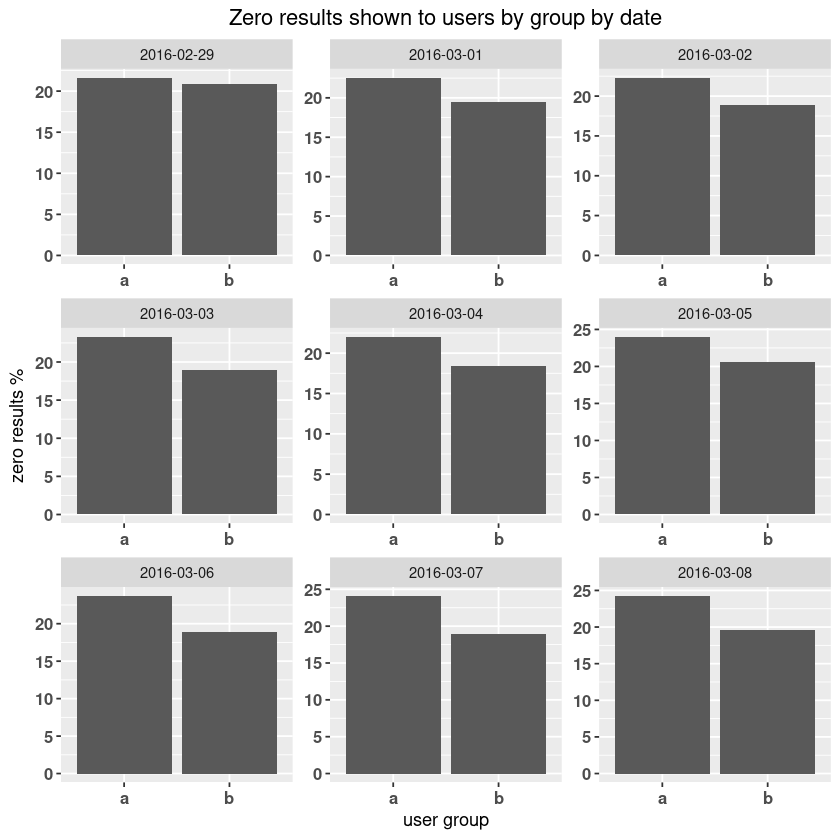

In [32]:
ggplot(data= zero_results_by_date, 
       aes(x=factor(user_group), y=percentage_zero_results)) + 
  geom_bar(stat="identity") + ylab("zero results %") + xlab("user group") + 
  theme(axis.text.x = element_text(face = "bold", size = 10),
        axis.text.y = element_text(face = "bold", size = 10),
        plot.title = element_text(hjust = 0.5)) +
  facet_wrap("date", scales = "free") +
  ggtitle("Zero results shown to users by group by date")

### The overall zero results by both the group of users a & b remain similar consistently throughout all days at a being only slightly higher than b 

# Key Take aways

## 1. the overall clickthrough rate in the whole dataset is ~39%, but the clickthrough rate varies a lot between the 2 user groups. While user group "a" have consistently around 65% to 68% and user group b around 18% to 21% accross all the days

## 2. Most of the users ~65% click on the first result, followed by ~14% on the second result. After the 7th result it is negligible. This behaviour remain consistent accross all the days

## 3.  the overall zero result rate in the whole dataset is ~21%, it does not vary much between the 2 user groups. While user group "a" have consistently around 21% to 23% and user group b around 19% to 20% accross all the days

## 4. The session length does not have any strong correlation with any of the given or computed features in the dataset. Although we can see a very small correlation between session length and no. of times the search page was visited in a single session. 

# Other Findings

## 1. Users from group b seem mostly like bots, scraping links since they have a disproportionately low clickthrough rate and seem to mostly visit the search page.  

## 2. The sampling rate of data collection is 10 seconds, which is quite low, as the users can easily move from one page to another before 10 seconds and many of their activities will not be registered.